In [8]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import wordle as wd


%load_ext autoreload
%autoreload 2

DATA_PATH = Path("../data/")
SAMPLE_WORDS_FNAME = "raw/sample_words.txt"
WORDS_PAIRS_FNAME = "transformed/guess_solution_map_{version}.pkl"

IMG_PATH = Path("../images/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating smaller scale set of allowed words

In [5]:
SAMPLE_WORDS_PATH = DATA_PATH / SAMPLE_WORDS_FNAME

sample_words = wd.load.load_words_as_dict(SAMPLE_WORDS_PATH)
test_psm = wd.player.map.PossibleSolutionsMap(sample_words, 
                                              list(sample_words))
test_psm.build_map()

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
print(list(sample_words)[:10])

['black', 'rowts', 'pharm', 'herls', 'relet', 'ensew', 'inane', 'dwaal', 'tasar', 'supra']


# Small Scale: Test Player Strategies
* down-sampling actual word lists:  possible words = allowed words = eval words.
* all have size = 200 words


In [17]:
config = {
    "player": wd.player.GreedyPlayer(test_psm),
    "path_to_eval_words_list": DATA_PATH / "raw/sample_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_test_v2.json",
    "fig_title": "v2 - test",
    "fig_name": IMG_PATH / "eval_test_v2.png",
}

results_v2, fig_v2 = wd.eval.run_eval_from_config(config)

EvalResults(size=200, avg_score=4.22, dist=[  0   0   0   4 149  46   1], success_rate=100.0%)
results saved in `../data/outputs/eval_test_v2.json`


## testing TwoStepPlayer

In [ ]:
player = wd.player.TwoStepPlayer(test_psm, "spaer")
game = wd.WordleGame("rowts")
TARGET_WORD = "rowts"

print(wd.player.play_game(
    wd.player.GreedyPlayer(test_psm), 
    game = wd.WordleGame(TARGET_WORD), 
    quiet=False))


print(wd.player.play_game(
    wd.player.TwoStepPlayer(test_psm, "spaer"), 
    game = wd.WordleGame(TARGET_WORD), 
    quiet=False))

WordleGame(target_word='ROWTS', max_guesses=6, number_of_guesses=3, is_over=True, solved=True)


WordleGame(target_word='ROWTS', max_guesses=6, number_of_guesses=2, is_over=True, solved=True)


In [13]:
tsp = wd.player.TwoStepPlayer(test_psm)
tsp.calculate_two_step_entropies(show_tqdm=True)

  0%|          | 0/200 [00:00<?, ?it/s]

,entropy_step_1,entropy_step_2,entropy_total
guess_word,,,
spaer,5.563859,2.039997,7.603856
parle,5.303026,2.287056,7.590082
earst,5.464717,2.099139,7.563856
orals,5.167297,2.396559,7.563856
salse,5.116616,2.443466,7.560082
...,...,...,...
feoff,2.962074,4.037103,6.999178
jukus,3.180877,3.812913,6.993790
cobby,2.974069,4.003495,6.977564


### Compare top results with and without $K$ set
* $K$ allows to reduce the number of next guesses considered to the top $K$ with the highest information gain, instead of considering all allowed words

In [14]:
tsp_limited = wd.player.TwoStepPlayer(test_psm, max_first_guesses=20)
display(tsp_limited.calculate_two_step_entropies(show_tqdm=True).head(10))



  0%|          | 0/20 [00:00<?, ?it/s]

,entropy_step_1,entropy_step_2,entropy_total
guess_word,,,
spaer,5.563859,2.039997,7.603856
parle,5.303026,2.287056,7.590082
earst,5.464717,2.099139,7.563856
orals,5.167297,2.396559,7.563856
salse,5.116616,2.443466,7.560082
reans,5.457097,2.102985,7.560082
poise,5.125003,2.435079,7.560082
peags,5.259187,2.300895,7.560082
slyer,5.140603,2.413253,7.553856


**Conclusions**: the top suggested guesses remain the same. this optimization seem to be reasonable.
To save on compute, we will now set `spaer` as the starting guess for all games played by the `TwoStepPlayer`.
## Evaluating TwoStepPlayer

In [15]:
config = {
    "player": wd.player.TwoStepPlayer(test_psm, starting_guess="spaer", max_first_guesses=20),
    "path_to_eval_words_list": DATA_PATH / "raw/sample_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_test_v2.json",
    "fig_title": "v2 - test",
    "fig_name": IMG_PATH / "eval_test_v2.png",
}

results_v3, fig = wd.eval.run_eval_from_config(config)

EvalResults(size=200, avg_score=4.21, dist=[  0   0   0   6 148  45   1], success_rate=100.0%)
results saved in `../data/outputs/eval_test_v2.json`


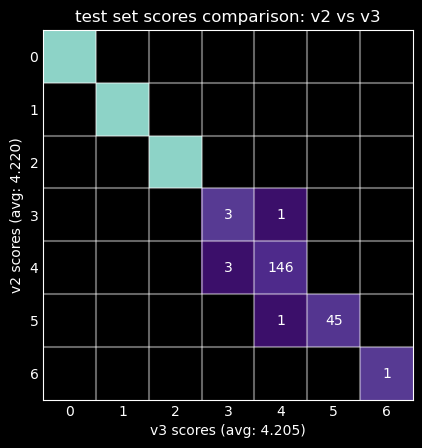

In [20]:
wd.display.plot_confusion_matrix(results_v2, results_v3, "v2", "v3");

### Observations
* despite having supposedly more insight into optimal guess strategy, `TwoStepPlayer` only improves on a single word, and even takes one extra guess for 4 other words.
* some further optimizations might be necessary.